WS | realizations 30/30 | elapsed 4.5 min | ETA 0.0 min
BA | realizations 30/30 | elapsed 4.5 min | ETA 0.0 min
ER | realizations 30/30 | elapsed 4.4 min | ETA 0.0 min
RR | realizations 30/30 | elapsed 4.2 min | ETA 0.0 min
Stars | realizations 30/30 | elapsed 3.9 min | ETA 0.0 min
Cave_bottleneck | realizations 30/30 | elapsed 4.1 min | ETA 0.0 min
Cave_random | realizations 30/30 | elapsed 3.9 min | ETA 0.0 min
Complete | realizations 5/5 | elapsed 11.3 min | ETA 0.0 min


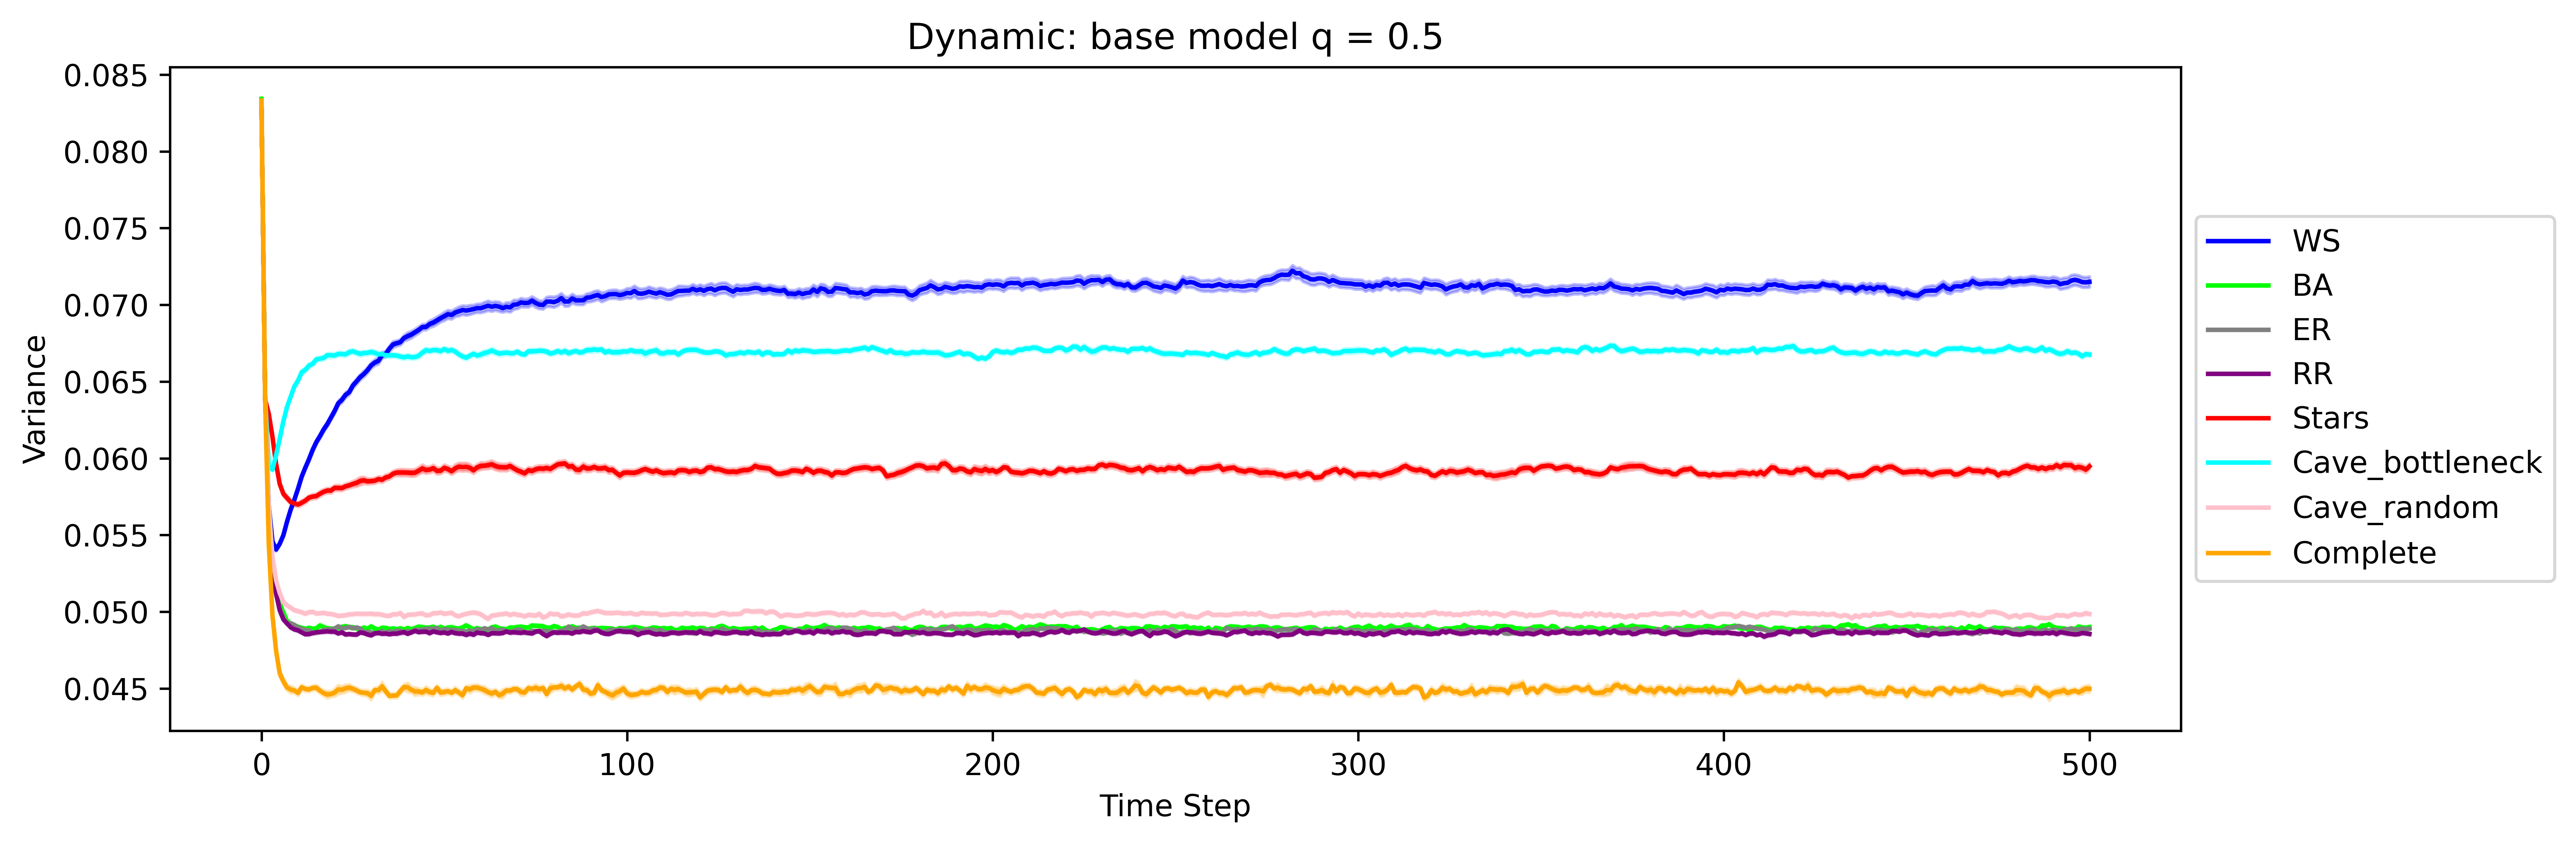

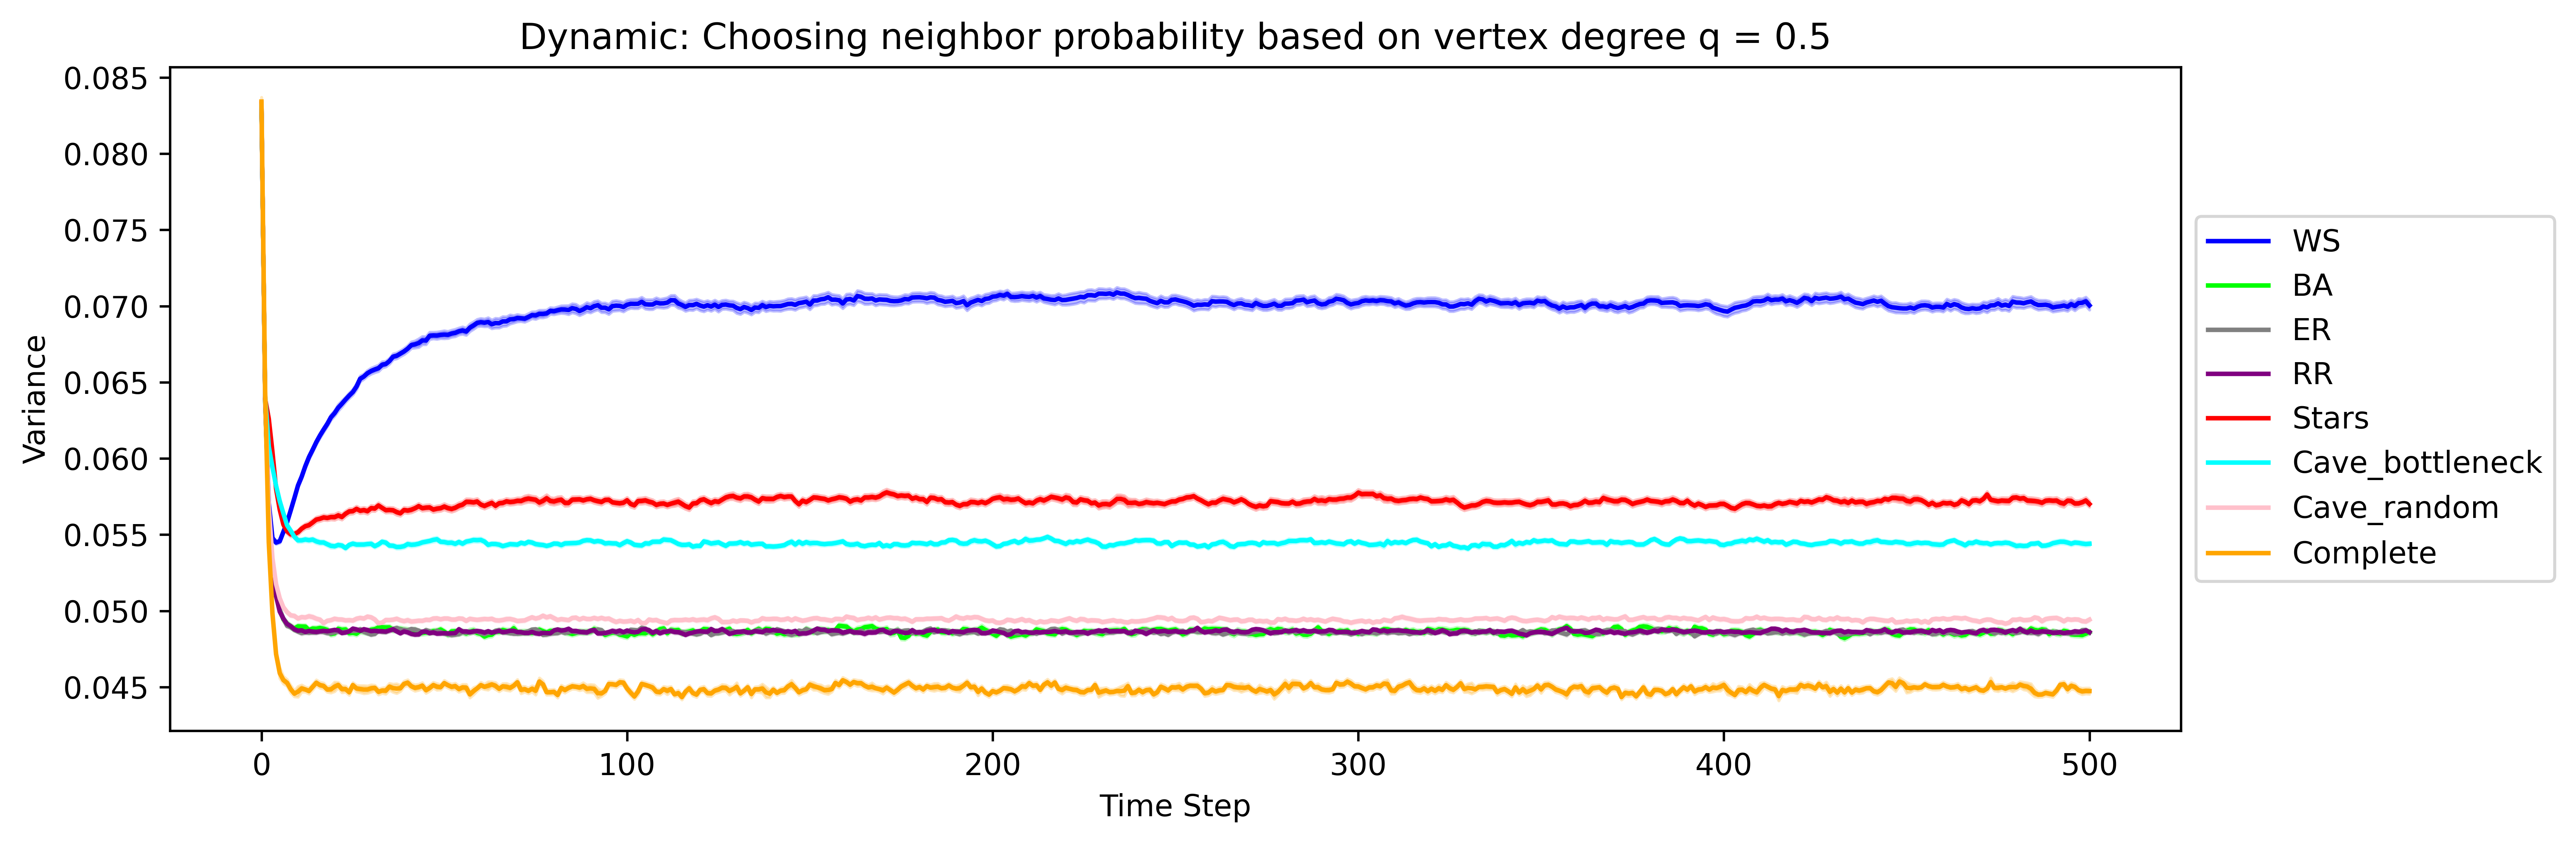

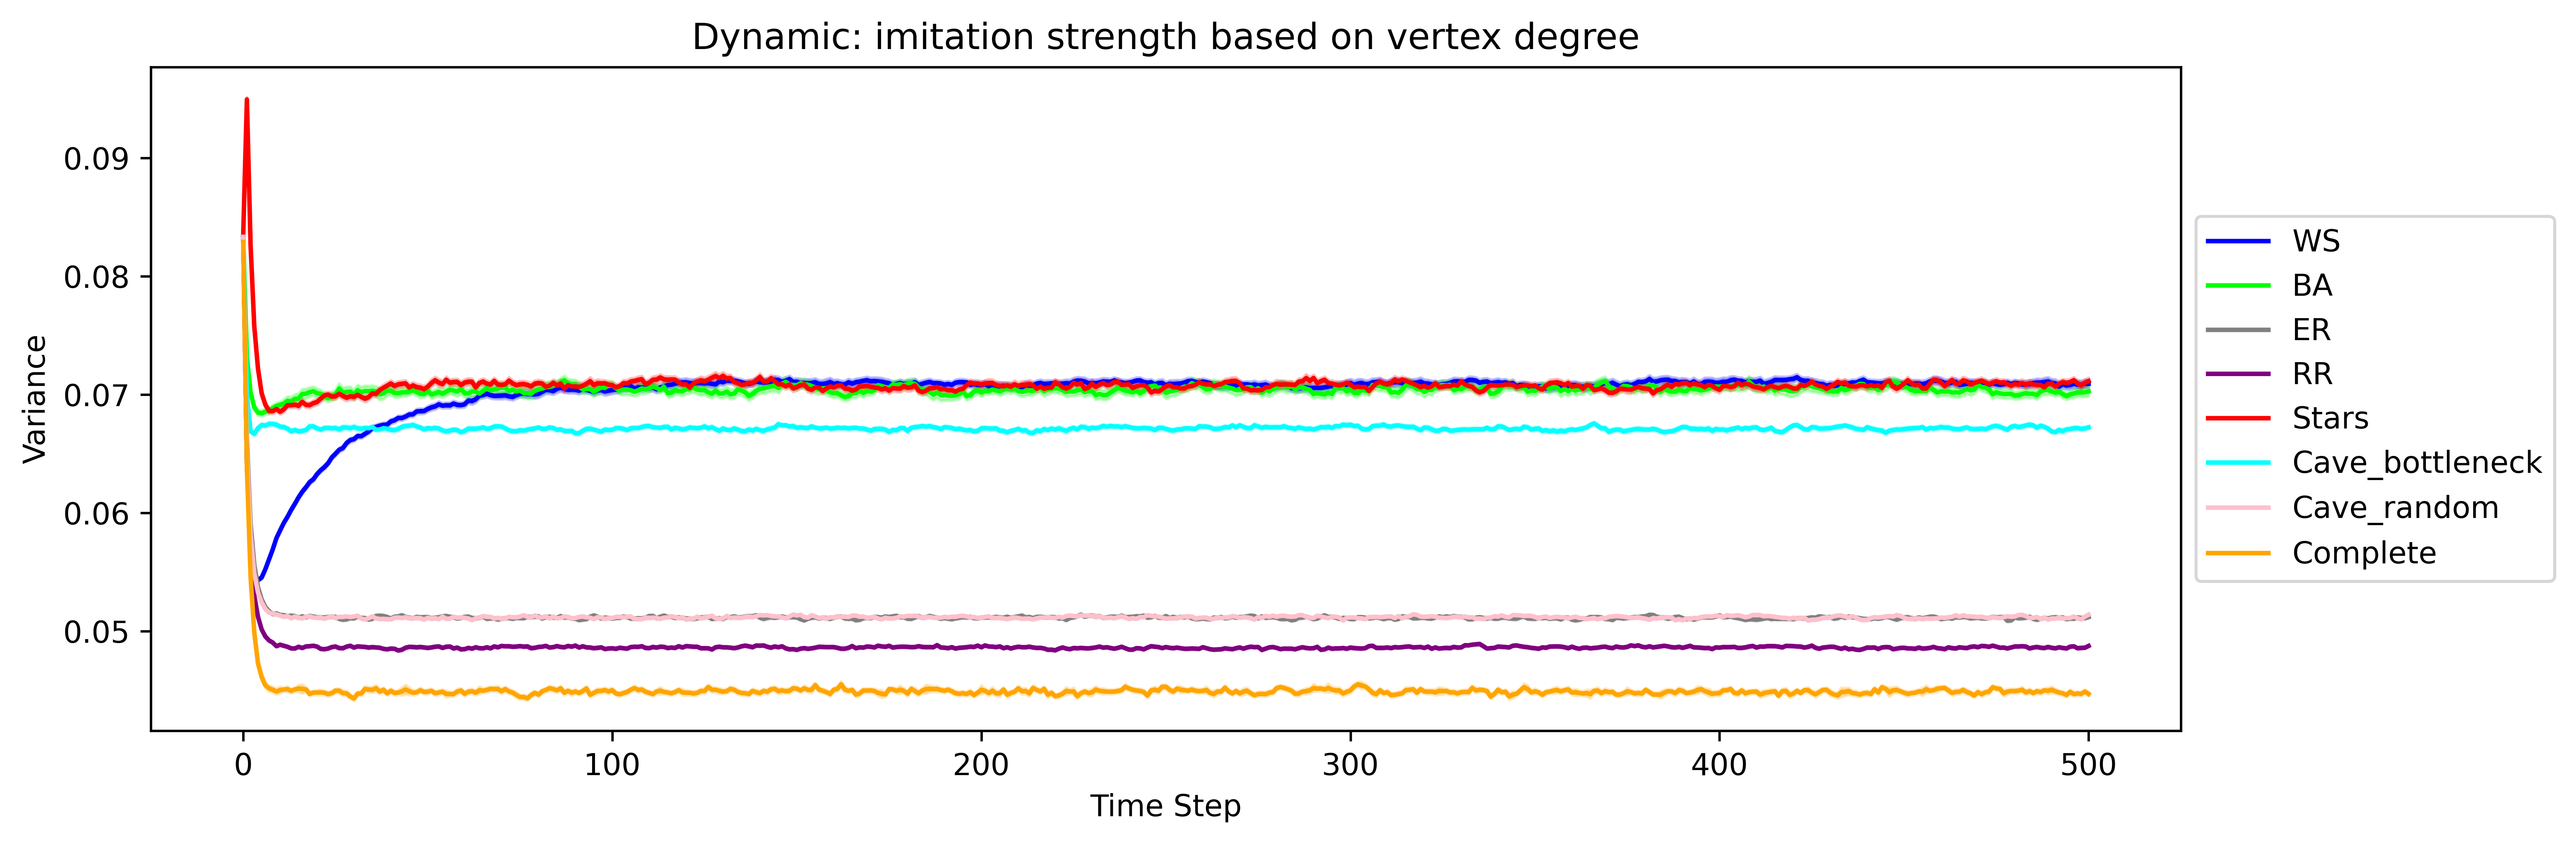

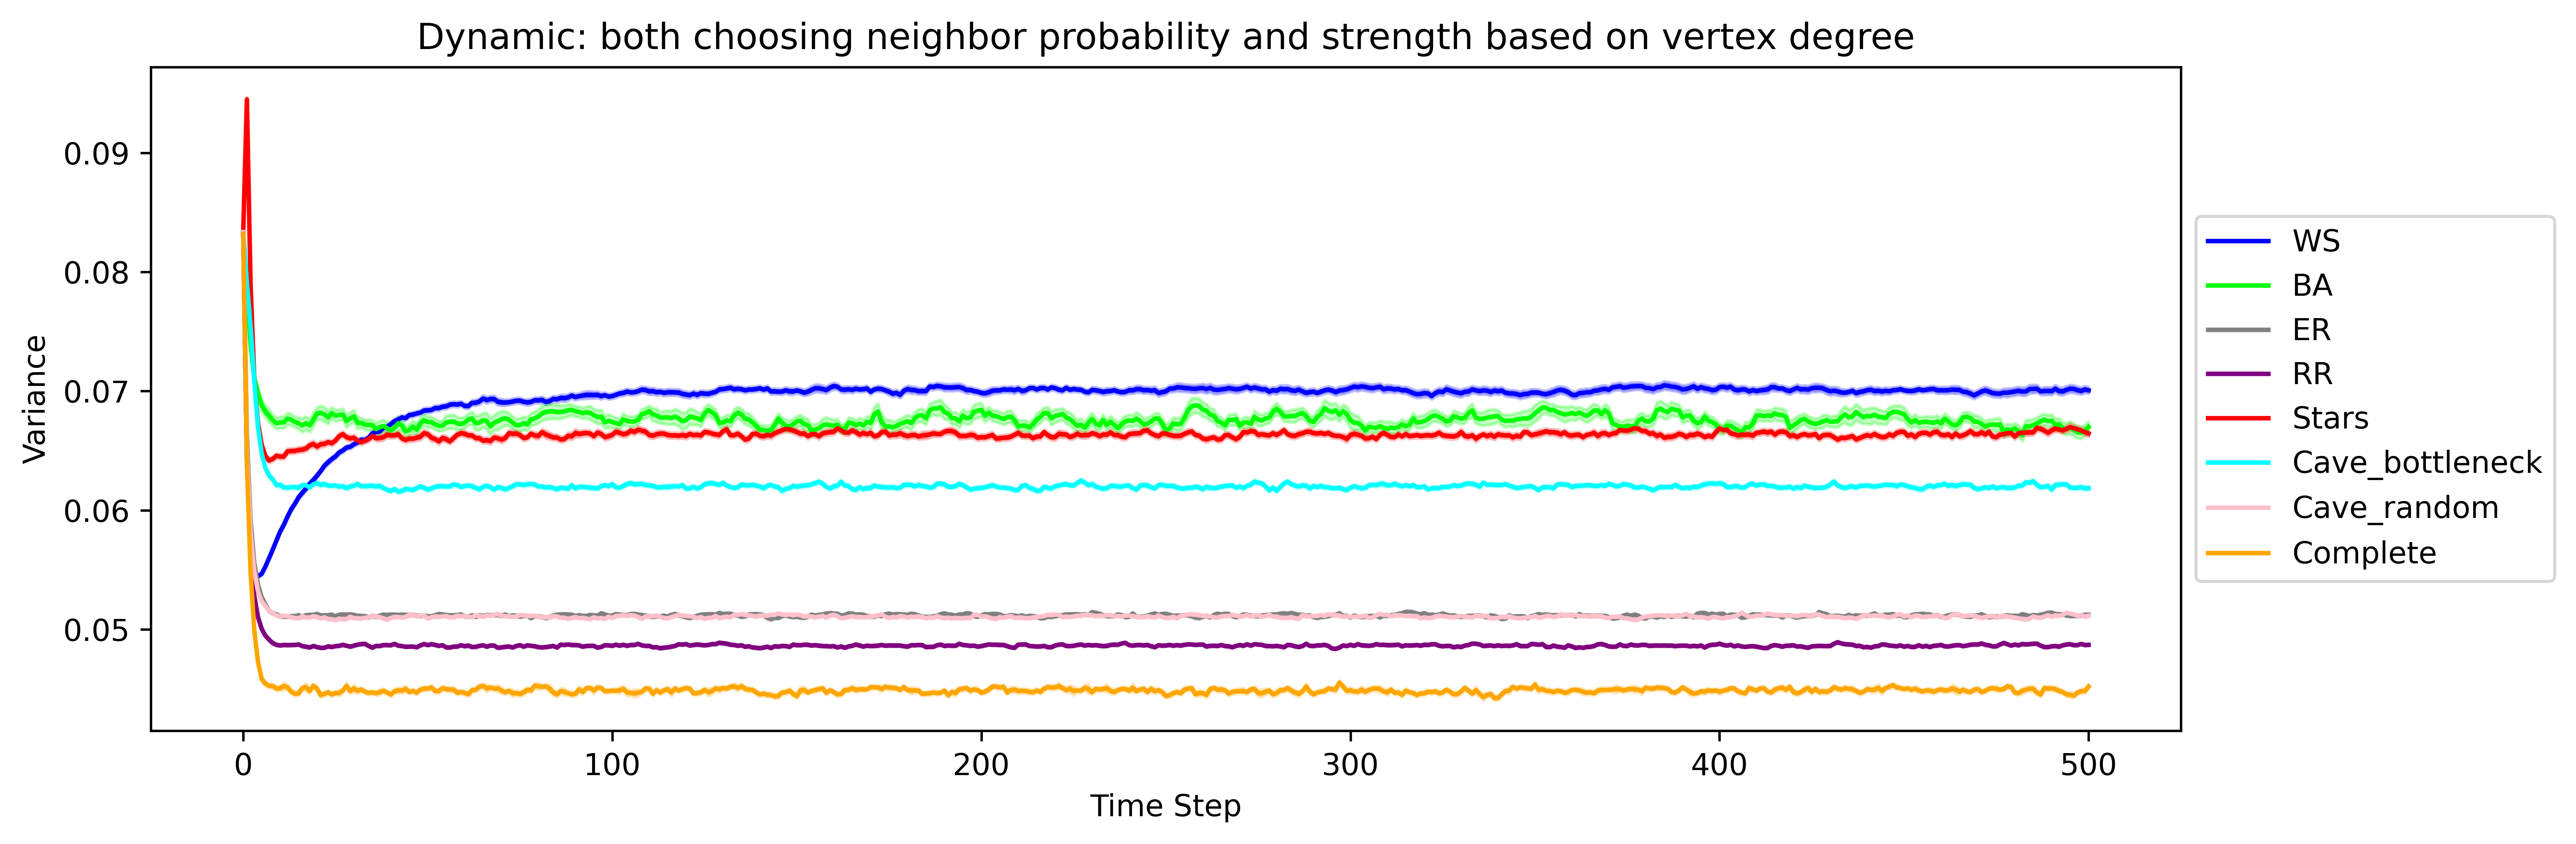

Saved: ./results\network_structure_metrics.csv
Saved: ./results\network_structure_metrics.tex
Saved CSVs to: ./results
Saved params CSV to: ./results\network_degree_matching_params.csv
Saved degree distributions to: ./results\degree_distributions


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from numba import njit
import pandas as pd
import math
import os
import time
from networkproperties import *
from creatingnetworks import *
from dynamicsfunctions import *


NEI_UNIFORM = 0
NEI_DEGPROB = 1


Q_FIXED   = 0
Q_DYNAMIC = 1

DYNAMICS = {
    "base model q = 0.5":      (NEI_UNIFORM, Q_FIXED),
    "Choosing neighbor probability based on vertex degree q = 0.5":   (NEI_DEGPROB, Q_FIXED),
    "imitation strength based on vertex degree":      (NEI_UNIFORM, Q_DYNAMIC),
    "both choosing neighbor probability and strength based on vertex degree":      (NEI_DEGPROB, Q_DYNAMIC),
}

DYN_NAMES = list(DYNAMICS.keys())

N                = 1000
max_steps        = 500
sigma            = 0.15
num_runs         = 30
num_realizations = 30

p_ws = 0.05
mu, p_i, p_e     = 0, 1, 1
start_step       = max_steps - 100
end_step         = max_steps
q                = 0.5

z_target         =  10 
l_fixed = 4
_star_seed_counter = 0
clique_size = 5
_clique_seed_counter = 0






def simulate_all_dynamics_same_network(
    create_net,
    num_realizations, num_runs,
    max_steps, sigma, N, mu, p_i, p_e,
    q_fixed, label=""
):
    """
    For each network realization:
      - generate G once
      - compute structural metrics ON THAT SAME G
      - run all 4 dynamics on that SAME G

    Returns:
      results: dict dyn -> {mean, sem, per_realization}
      net_struct: dict with per_real arrays + summary mean/sem
    """
    D = len(DYN_NAMES)

    per_real = np.zeros((num_realizations, D, max_steps + 1), dtype=float)
    per_real_runsem = np.zeros((num_realizations, D, max_steps + 1), dtype=float)  # NEW
    Ns = np.zeros(num_realizations, dtype=float)
    Es = np.zeros(num_realizations, dtype=float)
    Ks = np.zeros(num_realizations, dtype=float)
    Cs = np.zeros(num_realizations, dtype=float)
    Ls = np.zeros(num_realizations, dtype=float)
    Lam2 = np.zeros(num_realizations, dtype=float)
    pk_list = [] 
    t0= time.time()
    for r in range(num_realizations):
        G = create_net()

        if not nx.is_connected(G):
            raise RuntimeError("Graph is not connected. Fix create_net().")

        N0, E0, k0, C0, L0, lam2 = structural_metrics(G)
        Ns[r], Es[r], Ks[r], Cs[r], Ls[r], Lam2[r] = N0, E0, k0, C0, L0, lam2


        _, degrees, flat, ptr = prepare_network_data(G)
        k_vals, pk = degree_dist_from_degrees(degrees)
        pk_list.append(pk)
        runs_mean = np.zeros((D, max_steps + 1), dtype=float)
        for d, dyn_name in enumerate(DYN_NAMES):
            neighbor_mode, q_mode = DYNAMICS[dyn_name]
            runs_arr = np.zeros((num_runs, max_steps + 1), dtype=float)

            for run_idx in range(num_runs):
                # if is_complete:
                #     runs_arr[run_idx] = single_run_complete(
                #         max_steps, sigma, N, mu, p_i, p_e, q_fixed, q_mode
                #     )      
                    
                # else:
                runs_arr[run_idx] = single_run_general(
                    flat, ptr, degrees,
                    max_steps, sigma, N, mu, p_i, p_e,
                    q_fixed, neighbor_mode, q_mode
                )                              

            runs_mean[d] = runs_arr.mean(axis=0)
            # NEW: run SEM within this realization
            run_std = runs_arr.std(axis=0, ddof=1) if num_runs > 1 else np.zeros(max_steps + 1)
            runs_sem = run_std / np.sqrt(num_runs)
            per_real_runsem[r, d, :] = runs_sem  
        per_real[r] = runs_mean
        elapsed = time.time() - t0
        avg_per = elapsed / (r + 1)
        remaining = avg_per * (num_realizations - (r + 1))
        print(f"\r{label} realizations {r+1}/{num_realizations} | elapsed {elapsed/60:.1f} min | ETA {remaining/60:.1f} min", end="")

    print() 
    H = pad_and_stack_pk(pk_list)                
    pk_mean = H.mean(axis=0)
    pk_sem  = H.std(axis=0, ddof=1) / np.sqrt(H.shape[0]) if H.shape[0] > 1 else np.zeros_like(pk_mean)
    k = np.arange(len(pk_mean))

    results = {}

    for d, dyn_name in enumerate(DYN_NAMES):
        M = per_real[:, d, :]  
        Wv = per_real_runsem[:, d, :]  
        mean = M.mean(axis=0)
        within_var_mean = (Wv**2).mean(axis=0)                         
        var_Mr = M.var(axis=0, ddof=1) if num_realizations > 1 else np.zeros_like(mean)

        between_var = np.maximum(0.0, var_Mr - within_var_mean)
        sem_runs    = np.sqrt(within_var_mean / float(num_realizations))         
        sem_network = np.sqrt(between_var / float(num_realizations))              
        sem_total   = np.sqrt((within_var_mean + between_var) / float(num_realizations))  

        results[dyn_name] = {
            "mean": mean,
            "sem_total": sem_total,
            "sem_runs": sem_runs,
            "sem_network": sem_network,
            "per_realization": M,
              "per_realization_runsem": Wv,
        }
    def _mean_sem(x):
        m = float(np.mean(x))
        s = float(np.std(x, ddof=1) / np.sqrt(len(x))) if len(x) > 1 else 0.0
        return m, s

    net_struct = {
        "per_realization": {"N": Ns, "E": Es, "k_mean": Ks, "C": Cs, "L": Ls, "lambda2": Lam2},
        "summary": {
            "N_mean": _mean_sem(Ns)[0], "N_sem": _mean_sem(Ns)[1],
            "E_mean": _mean_sem(Es)[0], "E_sem": _mean_sem(Es)[1],
            "k_mean": _mean_sem(Ks)[0], "k_sem": _mean_sem(Ks)[1],
            "C_mean": _mean_sem(Cs)[0], "C_sem": _mean_sem(Cs)[1],
            "L_mean": _mean_sem(Ls)[0], "L_sem": _mean_sem(Ls)[1],
            "lambda2_mean": _mean_sem(Lam2)[0], "lambda2_sem": _mean_sem(Lam2)[1],
        },
        "degree_distribution": {"k": k, "pk_mean": pk_mean, "pk_sem": pk_sem},
    }

    return results, net_struct





k_ws, p_ws, m_ba, p_er, d_rr = degree_matching_params_standard(N, z_target, p_ws=p_ws)




_ENSURE_COUNTER = {}

def ensure_connected(make_graph, name="G", max_tries=200, seed0=None):

    if seed0 is None:
        c = _ENSURE_COUNTER.get(name, 0)
        seed0 = (c + 1) * 10_000
        _ENSURE_COUNTER[name] = c + 1

    for t in range(max_tries):
        seed = seed0 + t
        try:
            G = make_graph(seed)    
        except TypeError:
            G = make_graph()         

        if nx.is_connected(G):
            return G

    raise RuntimeError(f"{name}: could not generate a connected graph in {max_tries} tries.")

def create_ws():
    return ensure_connected(
        lambda seed: nx.watts_strogatz_graph(N, k_ws, p_ws, seed=seed),
        "WS"
    )

def create_ba():
    return ensure_connected(
        lambda seed: nx.barabasi_albert_graph(N, m_ba, seed=seed),
        "BA"
    )

def create_er():
    return ensure_connected(
        lambda seed: nx.erdos_renyi_graph(N, p_er, seed=seed),
        "ER"
    )

def create_rr():
    return ensure_connected(
        lambda seed: nx.random_regular_graph(d_rr, N, seed=seed),
        "RR"
    )

def create_cm():
    return nx.complete_graph(N)

def create_r(N=N, d_rr=d_rr):
    assert d_rr % 2 == 0, "Degree d_rr must be even"
    offsets = list(range(1, d_rr // 2 + 1))
    return nx.circulant_graph(N, offsets)


def create_star_backbone():
    global _star_seed_counter
    G, info = create_star_backbone_degree_matched(
        N=N,
        z_target=z_target,
        l_fixed=l_fixed,
        seed=1000 + _star_seed_counter,
        require_even_b=True
    )
    _star_seed_counter += 1
    return G

def create_cliques_added_edges():
    global _clique_seed_counter
    G, info = build_cliques_with_added_edges(
        N=N,
        clique_size=clique_size,
        z_target=z_target,
        backbone="ring",
        seed=2000 + _clique_seed_counter,
        tidy_mode="pairwise_roundrobin"
    )
    _clique_seed_counter += 1
    return G
_clique_bottleneck_counter = 0

def create_cliques_bottleneck():
    global _clique_bottleneck_counter
    G, info = build_cliques_gateway_only(
        N=N,
        clique_size=clique_size,
        z_target=z_target,
        backbone="ring",
        seed=3000 + _clique_bottleneck_counter
    )
    _clique_bottleneck_counter += 1
    return G


_clique_random_counter = 0

def create_cliques_random_added():
    global _clique_random_counter
    G, info = build_cliques_with_added_edges(
        N=N,
        clique_size=clique_size,
        z_target=z_target,
        backbone="ring",
        seed=4000 + _clique_random_counter,
        tidy_mode="random"     
    )
    _clique_random_counter += 1
    return G


NETWORKS = {
    "WS": create_ws,
    "BA": create_ba,
    "ER": create_er,
    "RR": create_rr,
    #"Regular" : create_r,
    "Stars": create_star_backbone,
    "Cave_bottleneck": create_cliques_bottleneck,
    "Cave_random": create_cliques_random_added,
    "Complete": create_cm
}

ALL = {}          
NETSTRUCT = {}   

for net_name, create_fn in NETWORKS.items():
    R_net = num_realizations
    if net_name in ["Complete"]:
        R_net = 5 

    res, ns = simulate_all_dynamics_same_network(
        create_fn,
        num_realizations=R_net,
        num_runs=num_runs,
        max_steps=max_steps,
        sigma=sigma,
        N=N,
        mu=mu, p_i=p_i, p_e=p_e,
        q_fixed=q ,  label=net_name + " |"
    )
    ALL[net_name] = res
    NETSTRUCT[net_name] = ns



colors = {
    "WS": "blue",
    "BA": "lime",
    "ER": "gray",
    "RR": "purple",
    #"Regular": "green",
    "Complete": "orange",
    "Stars": "red",
    "Cave_bottleneck": "cyan",
    "Cave_random": "pink",
}


t = np.arange(max_steps + 1)
out_dir = r"./results/plots"
for dyn in DYN_NAMES:
    plt.figure(figsize=(12, 4), dpi=600)
    plt.title(f"Dynamic: {dyn}", loc="center")
    # plt.text(
    #     0.02, 0.95, f"Dynamic: {dyn}",
    #     transform=plt.gca().transAxes,
    #     ha="right", va="top"
    # )

    for net_name in NETWORKS.keys():
        mean = ALL[net_name][dyn]["mean"]
        #sem  = ALL[net_name][dyn]["sem"]
        sem = ALL[net_name][dyn]["sem_total"]
        plt.plot(t, mean, label=net_name, color=colors[net_name])
        plt.fill_between(t, mean - sem, mean + sem, alpha=0.25,color=colors[net_name])

    plt.xlabel("Time Step")
    plt.ylabel("Variance")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"timeseries_variance_{dyn.replace(' ','_').replace('~','')}.jpg"))
    plt.show()
    


def window_mean(y, a, b):
    return float(np.mean(y[a:b+1]))

out_dir = r"./results"
os.makedirs(out_dir, exist_ok=True)

rows = []

for net_name, dyn_dict in ALL.items():
    for dyn_name, obj in dyn_dict.items():
        mean = obj["mean"]
        for t in range(len(mean)):
            rows.append({
                "network": net_name,
                "dynamic": dyn_name,
                "t": t,
                "variance_mean": float(mean[t]),
                "sem_total": float(obj.get("sem_total", np.nan)[t]),
                "sem_network": float(obj.get("sem_network", np.nan)[t]),
                "sem_runs": float(obj.get("sem_runs", np.nan)[t]),
            })


df_timeseries = pd.DataFrame(rows)
df_timeseries.to_csv(os.path.join(out_dir, "timeseries_variance.csv"), index=False)



rows1 = []
for net_name, ns in NETSTRUCT.items():
    s = ns["summary"]
    rows1.append({
        "network": net_name,
        "N": s["N_mean"], "N_SEM": s["N_sem"],
        "E": s["E_mean"], "E_SEM": s["E_sem"],
        "<k>": s["k_mean"], "<k>_SEM": s["k_sem"],
        "C": s["C_mean"], "C_SEM": s["C_sem"],
        "L": s["L_mean"], "L_SEM": s["L_sem"],
        "lambda2": s["lambda2_mean"],"lambda2_SEM": s["lambda2_sem"],

    })

df_net = pd.DataFrame(rows1)

csv_path = os.path.join(out_dir, "network_structure_metrics.csv")
df_net.to_csv(csv_path, index=False)
print("Saved:", csv_path)

tex_path = os.path.join(out_dir, "network_structure_metrics.tex")

df_net_tex = df_net.copy()

for col in ["N","E","<k>","C","L","lambda2","N_SEM","E_SEM","<k>_SEM","C_SEM","L_SEM","lambda2_SEM"]:
    df_net_tex[col] = df_net_tex[col].map(lambda x: f"{x:.4g}" if isinstance(x, (int,float)) else x)

latex_str = df_net_tex.to_latex(index=False, escape=False)
with open(tex_path, "w", encoding="utf-8") as f:
    f.write(latex_str)

print("Saved:", tex_path)


rows2 = []
for net_name, dyn_dict in ALL.items():
    for dyn_name, obj in dyn_dict.items():
        mean = obj["mean"]
        sem_net   = obj["sem_network"]   
        sem_runs  = obj["sem_runs"]      
        sem_total = obj["sem_total"]     

        rows2.append({
            "network": net_name,
            "dynamic": dyn_name,
            "steady_start": start_step,
            "steady_end": end_step,
            "steady_mean_variance": window_mean(mean, start_step, end_step),
            "steady_sem_network": window_mean(sem_net, start_step, end_step),
            "steady_sem_runs":    window_mean(sem_runs, start_step, end_step),
            "steady_sem_total":   window_mean(sem_total, start_step, end_step),
        })

df_steady = pd.DataFrame(rows2)
df_steady.to_csv(os.path.join(out_dir, "steady_state_summary.csv"), index=False)
print("Saved CSVs to:", out_dir)

param_rows = []

param_rows += [
    {"network": "WS", "param": "k_ws", "value": float(k_ws)},
    {"network": "WS", "param": "p_ws", "value": float(p_ws)},
    {"network": "BA", "param": "m_ba", "value": float(m_ba)},
    {"network": "ER", "param": "p_er", "value": float(p_er)},
    {"network": "RR", "param": "d_rr", "value": float(d_rr)},
]

# Regular (replace d_r with your variable name)
# param_rows += [
#     {"network": "Regular", "param": "d_regular", "value": float(d_rr)},  # <-- change d_r if needed
# ]

# Stars
s_star, l_star, b_star, achieved_star, b_ideal_star = star_backbone_params_degree_matched(
    N=N, z_target=z_target, l_fixed=l_fixed,
    require_even_b=True, enforce_connected_backbone=True
)
param_rows += [
    {"network": "Stars", "param": "l_fixed", "value": float(l_fixed)},
    {"network": "Stars", "param": "num_stars_s", "value": float(s_star)},
    {"network": "Stars", "param": "backbone_degree_b", "value": float(b_star)},
    {"network": "Stars", "param": "k_achieved_formula", "value": float(achieved_star)},
    {"network": "Stars", "param": "b_ideal", "value": float(b_ideal_star)},
]
k_lookup = dict(zip(df_net["network"], df_net["<k>"]))
ksem_lookup = dict(zip(df_net["network"], df_net["<k>_SEM"]))

param_rows.append({"network": "Stars", "param": "k_mean_realizations", "value": float(k_lookup["Stars"])})
param_rows.append({"network": "Stars", "param": "k_sem_realizations", "value": float(ksem_lookup["Stars"])})
param_rows.append({"network": "Cave_random", "param": "k_mean_realizations", "value": float(k_lookup["Cave_random"])})
param_rows.append({"network": "Cave_random", "param": "k_sem_realizations", "value": float(ksem_lookup["Cave_random"])})
param_rows.append({"network": "Cave_bottleneck", "param": "k_mean_realizations", "value": float(k_lookup["Cave_bottleneck"])})
param_rows.append({"network": "Cave_bottleneck", "param": "k_sem_realizations", "value": float(ksem_lookup["Cave_bottleneck"])})

params_rand = clique_addedge_params(N=N, clique_size=clique_size, z_target=z_target, backbone="ring")
for k, v in params_rand.items():
    if isinstance(v, (int, float, np.integer, np.floating)):
        param_rows.append({"network": "Cave_random", "param": str(k), "value": float(v)})

params_bneck = clique_gateway_params_degree_matched(N=N, clique_size=clique_size, z_target=z_target, backbone="ring")
for k, v in params_bneck.items():
    if isinstance(v, (int, float, np.integer, np.floating)):
        param_rows.append({"network": "Cave_bottleneck", "param": str(k), "value": float(v)})

df_params = pd.DataFrame(param_rows)
df_params.to_csv(os.path.join(out_dir, "network_degree_matching_params.csv"), index=False)

print("Saved params CSV to:", os.path.join(out_dir, "network_degree_matching_params.csv"))

deg_out = os.path.join(out_dir, "degree_distributions")
os.makedirs(deg_out, exist_ok=True)



deg_out = os.path.join(out_dir, "degree_distributions")
os.makedirs(deg_out, exist_ok=True)

for net_name, ns in NETSTRUCT.items():
    dd = ns.get("degree_distribution")
    if dd is None:
        continue

    df_deg = pd.DataFrame({
        "k": dd["k"],
        "pk_mean": dd["pk_mean"],
        "pk_sem": dd["pk_sem"],
    })

    if (df_deg["pk_mean"] > 0).any():
        last = df_deg.index[df_deg["pk_mean"] > 0].max()
        df_deg = df_deg.iloc[:last + 1]

    csv_path = os.path.join(deg_out, f"degdist_{net_name}.csv")
    df_deg.to_csv(csv_path, index=False)

    k = df_deg["k"].to_numpy()
    pk = df_deg["pk_mean"].to_numpy()
    pk_sem = df_deg["pk_sem"].to_numpy()

    plt.figure(figsize=(5, 4), dpi=300)
    plt.bar(k, pk, width=1.0, align="center", edgecolor="gray", linewidth=0.6)
    plt.errorbar(k, pk, yerr=pk_sem, fmt="none", ecolor="gray", elinewidth=0.8, capsize=2)

    plt.xlabel("Degree k")
    plt.ylabel("Probability P(k)")
    plt.title(f"Degree Distribution — {net_name}")
    plt.tight_layout()
    plt.savefig(os.path.join(deg_out, f"degdist_{net_name}.png"))
    plt.close()

print("Saved degree distributions to:", deg_out)
